In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# Value Object for our neural net graph

class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        
        return out
    
    def __radd__(self, other) -> 'Value':
        return self + other
    
    def __mul__(self, other) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __rmul__(self, other) -> 'Value':
        return self * other
    
    # TODO: support exponentiation on Value node

    # TODO: support division on Value node

    def tanh(self) -> 'Value':
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out
    
    def backward(self) -> None:
        topo: list[Value] = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [13]:
# helper function for graphing NN

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

![Artifical Neuron](./resources/artificial-neuron.webp)

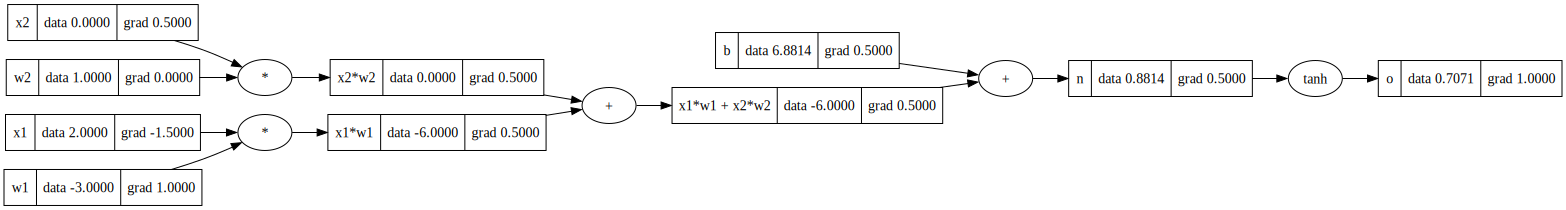

In [14]:
# Single Neuron

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights (synaptic strength, scales the related input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron itself, how much it wants to encourage or supress activation
# (bias was arbitrarily chosen to give us near-integer values)
b = Value(6.8813735870195432, label='b')

# computational graph for this neuron ie sum_all(xn * wn)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
sum_all_inputs = x1w1 + x2w2; sum_all_inputs.label = 'x1*w1 + x2*w2'
n = sum_all_inputs + b; n.label = 'n'

# activation function will determine if it fires or not, so say, only if positive
o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

In [15]:
# more optimizations - upgrade ints/floats to Values implictly

a = Value(2.0)
b = 2 * a

b

Value(data=4.0)